In [1]:
import pandas as pd, numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.feature_selection import SelectKBest, SelectPercentile, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from os import listdir

sns.set(
    font="ABC Sans Nova"
)

metadata = pd.read_excel(
    "./metadata.xlsx",
    sheet_name=1,
    header=10
)

file_names = listdir("./census_data")
file_names = sorted([file_name for file_name in file_names if ".csv" in file_name])

for i, file_name in enumerate(file_names):
    
    key = file_name.split("_")[1]
    
    file_data = pd.read_csv(
        f"./census_data/{file_name}",
        index_col="SAL_CODE_2021"
    )
    
    file_data.columns = [
        metadata[
            (metadata.DataPackfile == key) &
            (metadata.Short == string)
        ].iat[0, 2].lower() for string in file_data.columns
    ]
            
    if i == 0:
        suburb_data = file_data
    
    else:        
        suburb_data = suburb_data.join(
            file_data,
            lsuffix=f"_v{i}"
        )

suburb_data.to_csv("./raw_suburb_data.csv")

act_suburbs = pd.read_csv(
    "./act_suburbs.csv"
)
act_suburbs.code = "SAL" + act_suburbs.code.astype("str")

In [27]:
data = pd.DataFrame(
    index=act_suburbs.code,
    data={
        "name": act_suburbs.name.to_list(),
        "belco":  act_suburbs.belco.to_list()
    }
)

data["population"] = suburb_data.total_persons_persons
data = data[data.population >= 30]
suburb_data = suburb_data.loc[data.index]

data["masculinity"] = suburb_data.total_persons_males / data.population
data["age_under_5"] = suburb_data.age_groups_0_4_years_persons / data.population
data["age_under_15"] = suburb_data.age_groups_5_14_years_persons / data.population + data.age_under_5
data["age_under_20"] = suburb_data.age_groups_15_19_years_persons / data.population + data.age_under_15
data["age_under_25"] = suburb_data.age_groups_20_24_years_persons / data.population + data.age_under_20
data["age_under_35"] = suburb_data.age_groups_25_34_years_persons / data.population + data.age_under_25
data["age_under_45"] = suburb_data.age_groups_35_44_years_persons / data.population + data.age_under_35
data["age_under_55"] = suburb_data.age_groups_45_54_years_persons / data.population + data.age_under_45
data["age_under_65"] = suburb_data.age_groups_55_64_years_persons / data.population + data.age_under_55
data["age_under_75"] = suburb_data.age_groups_65_74_years_persons / data.population + data.age_under_65
data["age_under_85"] = suburb_data.age_groups_75_84_years_persons / data.population + data.age_under_75
data["indigenous"] = suburb_data.aboriginal_and_or_torres_strait_islander_persons_total_persons / data.population
data["born_overseas"] = suburb_data.birthplace_elsewhere_persons / data.population
data["other_language"] = suburb_data.language_used_at_home_other_language_persons / data.population
data["citizens"] = suburb_data.australian_citizen_persons / data.population
data["median_age"] = suburb_data.median_age_of_persons
data["median_mortgage_repayment"] = suburb_data.median_mortgage_repayment_monthly
data["median_personal_income"] = suburb_data.median_total_personal_income_weekly
data["median_rent"] = suburb_data.median_rent_weekly
data["median_family_income"] = suburb_data.median_total_family_income_weekly
data["avg_people_bedroom"] = suburb_data.average_number_of_persons_per_bedroom
data["median_household_income"] = suburb_data.median_total_household_income_weekly
data["avg_household_size"] = suburb_data.average_household_size
# data["marriage_divorce_ratio_men"] = suburb_data.males_total_married / suburb_data.males_total_divorced
# data["marriage_divorce_ratio_women"] = suburb_data.females_total_married / suburb_data.females_total_divorced
data["marriage_divorce_ratio"] = suburb_data.persons_total_married / suburb_data.persons_total_divorced
data["australian_parents"] = suburb_data.australian_both_parents_born_in_australia / data.population

countries = [
    ["afghanistan"],
    ["bangladesh"],
    ["bosnia and herzegovina"],
    ["brazil"],
    ["cambodia"],
    ["canada"],
    ["chile"],
    ["china", "china excludes sars and taiwan"],
    ["croatia"],
    ["egypt"],
    ["england"],
    ["egypt"],
    ["fiji"],
    ["france"],
    ["germany"],
    ["greece"],
    ["hong kong", "hong kong sar of china"],
    ["india"],
    ["indonesia"],
    ["iran"],
    ["iraq"],
    ["ireland"],
    ["italy"],
    ["japan"],
    ["korea", "korea republic of south"],
    ["lebanon"],
    ["malaysia"],
    ["malta"],
    ["mauritius"],
    ["myanmar"],
    ["nepal"],
    ["netherlands"],
    ["new zealand"],
    ["north macedonia"],
    ["pakistan"],
    ["papua new guinea"],
    ["philippines"],
    ["poland"],
    ["samoa"],
    ["scotland"],
    ["singapore"],
    ["south africa"],
    ["sri lanka"],
    ["taiwan"],
    ["thailand"],
    ["turkey"],
    ["usa", "united states of america"],
    ["vietnam"],
    ["wales"],
    ["zimbabwe"]
]

for country in countries:
    if len(country) == 1:
        string = country[0].replace(" ", "_")
    else:
        string = country[1].replace(" ", "_")
    try:
        data[f"{country[0].replace(' ', '_')}_born"] = suburb_data[f"persons_{string}_total"] / data.population
    except:
        data[f"{country[0].replace(' ', '_')}_born"] = suburb_data[f"persons_{string}_age_total"] / data.population

data

,name,belco,population,masculinity,age_under_5,age_under_15,age_under_20,age_under_25,age_under_35,age_under_45,...,singapore_born,south_africa_born,sri_lanka_born,taiwan_born,thailand_born,turkey_born,usa_born,vietnam_born,wales_born,zimbabwe_born
code,,,,,,,,,,,,,,,,,,,,,
SAL80017,Acton,0,2848.0,0.448385,0.001756,0.001756,0.510885,0.883076,0.976826,0.994733,...,0.011587,0.008076,0.005267,0.002107,0.003862,0.000000,0.013343,0.003511,0.000000,0.000000
SAL80018,Ainslie,0,5376.0,0.471726,0.048549,0.166481,0.221726,0.294457,0.406622,0.535714,...,0.001116,0.005394,0.002790,0.000000,0.001488,0.000744,0.016555,0.010603,0.000744,0.001302
SAL80019,Amaroo,0,6129.0,0.495676,0.060858,0.226138,0.305760,0.370370,0.498287,0.654430,...,0.002774,0.007016,0.009953,0.001795,0.002774,0.000816,0.004732,0.007995,0.000816,0.000489
SAL80020,Aranda,1,2605.0,0.487524,0.054511,0.196929,0.251440,0.314395,0.418042,0.550480,...,0.001536,0.004223,0.003839,0.001152,0.003071,0.001152,0.016123,0.003071,0.000000,0.002687
SAL80021,Banks,0,5100.0,0.499020,0.062549,0.212353,0.280588,0.349412,0.497255,0.648627,...,0.002353,0.001765,0.007647,0.000000,0.002941,0.000000,0.004118,0.004706,0.000000,0.000588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SAL80131,Watson,0,6727.0,0.484466,0.065408,0.199792,0.246767,0.313215,0.502453,0.687379,...,0.003122,0.004014,0.003865,0.000892,0.002378,0.001189,0.011000,0.009663,0.000595,0.001041
SAL80132,Weetangera,1,2795.0,0.499106,0.046512,0.184258,0.260107,0.318068,0.419678,0.547406,...,0.001073,0.002504,0.002147,0.001431,0.001431,0.003220,0.011449,0.013596,0.002504,0.001073
SAL80133,Weston,0,4000.0,0.483250,0.057000,0.189500,0.241500,0.288500,0.393500,0.535500,...,0.002750,0.004750,0.006500,0.001750,0.003250,0.000000,0.007000,0.003250,0.002000,0.001000


In [28]:
suburb_data.columns.tolist()

['total_persons_males',
 'total_persons_females',
 'total_persons_persons',
 'age_groups_0_4_years_males',
 'age_groups_0_4_years_females',
 'age_groups_0_4_years_persons',
 'age_groups_5_14_years_males',
 'age_groups_5_14_years_females',
 'age_groups_5_14_years_persons',
 'age_groups_15_19_years_males',
 'age_groups_15_19_years_females',
 'age_groups_15_19_years_persons',
 'age_groups_20_24_years_males',
 'age_groups_20_24_years_females',
 'age_groups_20_24_years_persons',
 'age_groups_25_34_years_males',
 'age_groups_25_34_years_females',
 'age_groups_25_34_years_persons',
 'age_groups_35_44_years_males',
 'age_groups_35_44_years_females',
 'age_groups_35_44_years_persons',
 'age_groups_45_54_years_males',
 'age_groups_45_54_years_females',
 'age_groups_45_54_years_persons',
 'age_groups_55_64_years_males',
 'age_groups_55_64_years_females',
 'age_groups_55_64_years_persons',
 'age_groups_65_74_years_males',
 'age_groups_65_74_years_females',
 'age_groups_65_74_years_persons',
 'age_

In [25]:
data.columns

Index(['name', 'belco', 'population', 'masculinity', 'age_under_5',
       'age_under_15', 'age_under_20', 'age_under_25', 'age_under_35',
       'age_under_45', 'age_under_55', 'age_under_65', 'age_under_75',
       'age_under_85', 'indigenous', 'born_overseas', 'other_language',
       'citizens', 'median_age', 'median_mortgage_repayment',
       'median_personal_income', 'median_rent', 'median_family_income',
       'avg_people_bedroom', 'median_household_income', 'avg_household_size',
       'marriage_divorce_ratio', 'australian_parents', 'afghanistan_born',
       'bangladesh_born', 'bosnia and herzegovina_born', 'brazil_born',
       'cambodia_born', 'canada_born', 'chile_born', 'china_born',
       'croatia_born', 'egypt_born', 'england_born', 'fiji_born',
       'france_born', 'germany_born', 'greece_born', 'hong kong_born',
       'india_born', 'indonesia_born', 'iran_born', 'iraq_born',
       'ireland_born', 'italy_born', 'japan_born', 'korea_born',
       'lebanon_born', 'm

<AxesSubplot:xlabel='india_born', ylabel='Count'>

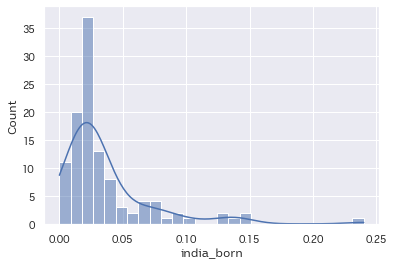

In [33]:
sns.histplot(
    data=data.india_born,
    kde=True
)

In [36]:
X = data.iloc[:, 3:]
y = data.loc[:, "belco"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    random_state=0,
    test_size=0.25
)
clf = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(n_jobs=4))
]).fit(X_train, y_train)

mi_scores = pd.Series(
    index=X.columns,
    data=mutual_info_classif(X, y)
).sort_values(ascending=False)

# selector = SelectKBest(
#     mutual_info_classif,
#     k=5
# )
# X_reduced = selector.fit_transform(X, y)

mi_scores.head(50)


mauritius_born             0.103644
south_africa_born          0.097559
age_under_5                0.074790
avg_household_size         0.065640
ireland_born               0.049084
thailand_born              0.045548
age_under_15               0.044808
age_under_85               0.042342
vietnam_born               0.040131
age_under_75               0.038677
singapore_born             0.036837
pakistan_born              0.036378
age_under_45               0.035176
age_under_20               0.033442
italy_born                 0.033200
median_personal_income     0.031539
china_born                 0.031512
median_rent                0.031016
myanmar_born               0.025351
age_under_55               0.025047
france_born                0.023642
indonesia_born             0.022523
age_under_35               0.021853
avg_people_bedroom         0.021431
cambodia_born              0.020678
croatia_born               0.017225
nepal_born                 0.015835
bangladesh_born            0